First, let's load the data from the files:

In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv('train.csv')
test_data = test_data = pd.concat([pd.read_csv('test.csv'), 
                                   pd.read_csv('gender_submission.csv')['Survived']], axis=1)

Let's look at the data:

In [274]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [275]:
train_data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
760,761,0,3,"Garfirth, Mr. John",male,NaN,0,0,358585,14.500,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.500,NaN,S
402,403,0,3,"Jussila, Miss. Mari Aina",female,21.00,1,0,4137,9.825,NaN,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.375,B57 B59 B63 B66,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00,0,0,A/5. 2151,8.050,NaN,S


The data seems consistent across the dataframe. Now let's look at how many unique values each column contains:

In [276]:
for col in train_data:
    print(f'{col} - {len(train_data[col].unique())}')

PassengerId - 891
Survived - 2
Pclass - 3
Name - 891
Sex - 2
Age - 89
SibSp - 7
Parch - 7
Ticket - 681
Fare - 248
Cabin - 148
Embarked - 4


Let's check if there is missing data, how much and in which columns:

In [277]:
print(f'train_data has {train_data.shape[0]} rows in total')
for col in train_data:
    if not train_data[col].isna().any():
        continue
        
    print(f'The column {col} contains {train_data[col].isna().sum()} NA values')

train_data has 891 rows in total
The column Age contains 177 NA values
The column Cabin contains 687 NA values
The column Embarked contains 2 NA values


I have decided to remove the rows with missing Embarked cells, because there are only 2 of them; to fill the Age cell with the mean of nearest neighbors (using KNNImpute); and to remove the Cabin column because most values are missing and the others are many categories with one or only a few points in them. We also don't need the Name and Ticket columns for the same reason as the Cabin column (except they don't have missing values) and we don't neet the PassengerId column as it is redundant due to having the pandas dataframe's index. Let's do all this in code:

In [518]:
from sklearn.impute import SimpleImputer, KNNImputer

def clean_data(df):
    df = pd.DataFrame(df)
    df = df.dropna(subset=['Embarked', 'Fare'])

    knn_imputer = KNNImputer(n_neighbors=3)
    age_data = df['Age'].values.reshape(-1, 1)
    imputed_age_data = knn_imputer.fit_transform(age_data)
    df['Age'] = imputed_age_data

    del df['Cabin']
    del df['Name']
    del df['PassengerId']
    del df['Ticket']

    df = df.reset_index(drop=True)
    return df

train_data_cleaned = clean_data(train_data)

We also had to reset index in order to avoid issues when using this dataframe later on, because we have removed some rows and the index should be updated. 

Now let's write a simple one-hot encode function for categorical types:

In [519]:
def one_hot_encode(name, df):
    labels = sorted(df.unique())
    count = len(labels)
    labels_dict = {labels[i]: i for i in range(count)}
    
    result = np.empty((df.shape[0], count - 1), dtype=np.uint8)
    for i, row in enumerate(df):
        num = labels_dict[row]
        for j in range(count - 1):
            result[i, j] = 1 if j == num else 0
    
    result_df = pd.DataFrame(result)
    result_df = result_df.rename(columns=lambda num: name + '=' + str(labels[num]))
    return result_df

This function encodes n-dimensional categories with n - 1 numbers, as the nth one is reduntant. 

Now let's check if it works (keep in mind that there are 3 unique values in Embarked now, because NA values were removed):

In [521]:
for col in train_data_cleaned:
    if col not in ['Fare', 'Age', 'Parch', 'SibSp']:
        encoded = one_hot_encode(col, train_data_cleaned[col])
        print(encoded.head())

   Survived=0
0           1
1           0
2           0
3           0
4           1
   Pclass=1  Pclass=2
0         0         0
1         1         0
2         0         0
3         1         0
4         0         0
   Sex=female
0           0
1           1
2           1
3           1
4           0
   Embarked=C  Embarked=Q
0           0           0
1           1           0
2           0           0
3           0           0
4           0           0


Before normalizing the data we should check for outliers and look at the mean and deviation. Parch and SibSp are considered numeric as they are ordinal categories.

In [522]:
for col in ['Age', 'Fare', 'Parch', 'SibSp']:
    print(col, train_data_cleaned[col].unique().min(), train_data_cleaned[col].unique().max(),
          round(train_data_cleaned[col].mean(), 2), round(train_data_cleaned[col].std(), 2))

Age 0.42 80.0 29.64 12.97
Fare 0.0 512.3292 32.1 49.7
Parch 0 6 0.38 0.81
SibSp 0 8 0.52 1.1


Seems like the column Fare contains some outliers. Let's look into it:

<Axes: >

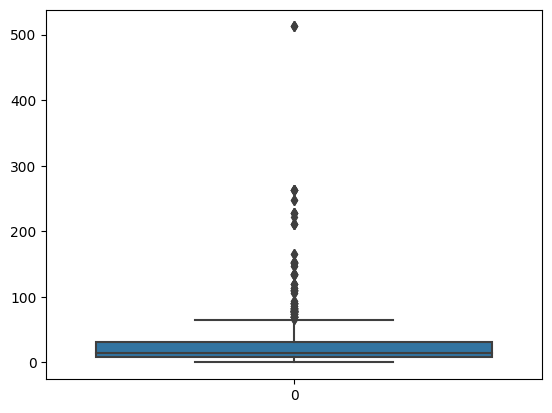

In [523]:
sns.boxplot(data=train_data_cleaned['Fare'])

This is most likely not a measuring error, looking at the domain, but this still could pose a problem for some algorithms. But in this case clustering algorithms work well enough even without removing these outliers, so we won't touch this column.

For now let's one-hot encode all the categorical columns and normalize all the numeric columns. We will also create two separate dataframes at this step: one for visualization and one for clustering.

In [524]:
def process_df(df):
    dfs = []
    rows = df.shape[0]
    dfs_visualization_only = []
    dfs_clustering_only = []
    for col in df:
        if col in ['Age', 'Fare', 'Parch', 'SibSp']:
            cd = df[col]
            cd = (cd - cd.min()) / (cd.max() - cd.min())
            dfs.append(pd.DataFrame(cd))
        else:
            encoded = one_hot_encode(col, df[col])
            if len(df[col].unique()) == 2:
                if col != 'Survived':
                    dfs.append(encoded)
                else:
                    dfs_visualization_only.append(encoded)
            else:
                dfs_clustering_only.append(encoded)
                if (df[col].dtype == object):
                    labels = sorted(df[col].unique())
                    labels_dict = {labels[i]: i for i in range(len(labels))}
                    df_for_value = pd.DataFrame([labels_dict[k] for k in df[col]], columns=[col])
                    dfs_visualization_only.append(df_for_value.astype(np.uint8))
                else:
                    dfs_visualization_only.append(df[col].astype(np.uint8))

    df_processed = pd.concat([*dfs, *dfs_clustering_only], axis=1)
    df_for_visualization = pd.concat([*dfs, *dfs_visualization_only], axis=1)
    return df_processed, df_for_visualization

In [525]:
train_data_processed, train_data_for_visualization = process_df(train_data_cleaned)

Now let's visualize relationships between all the variables in this dataframe:

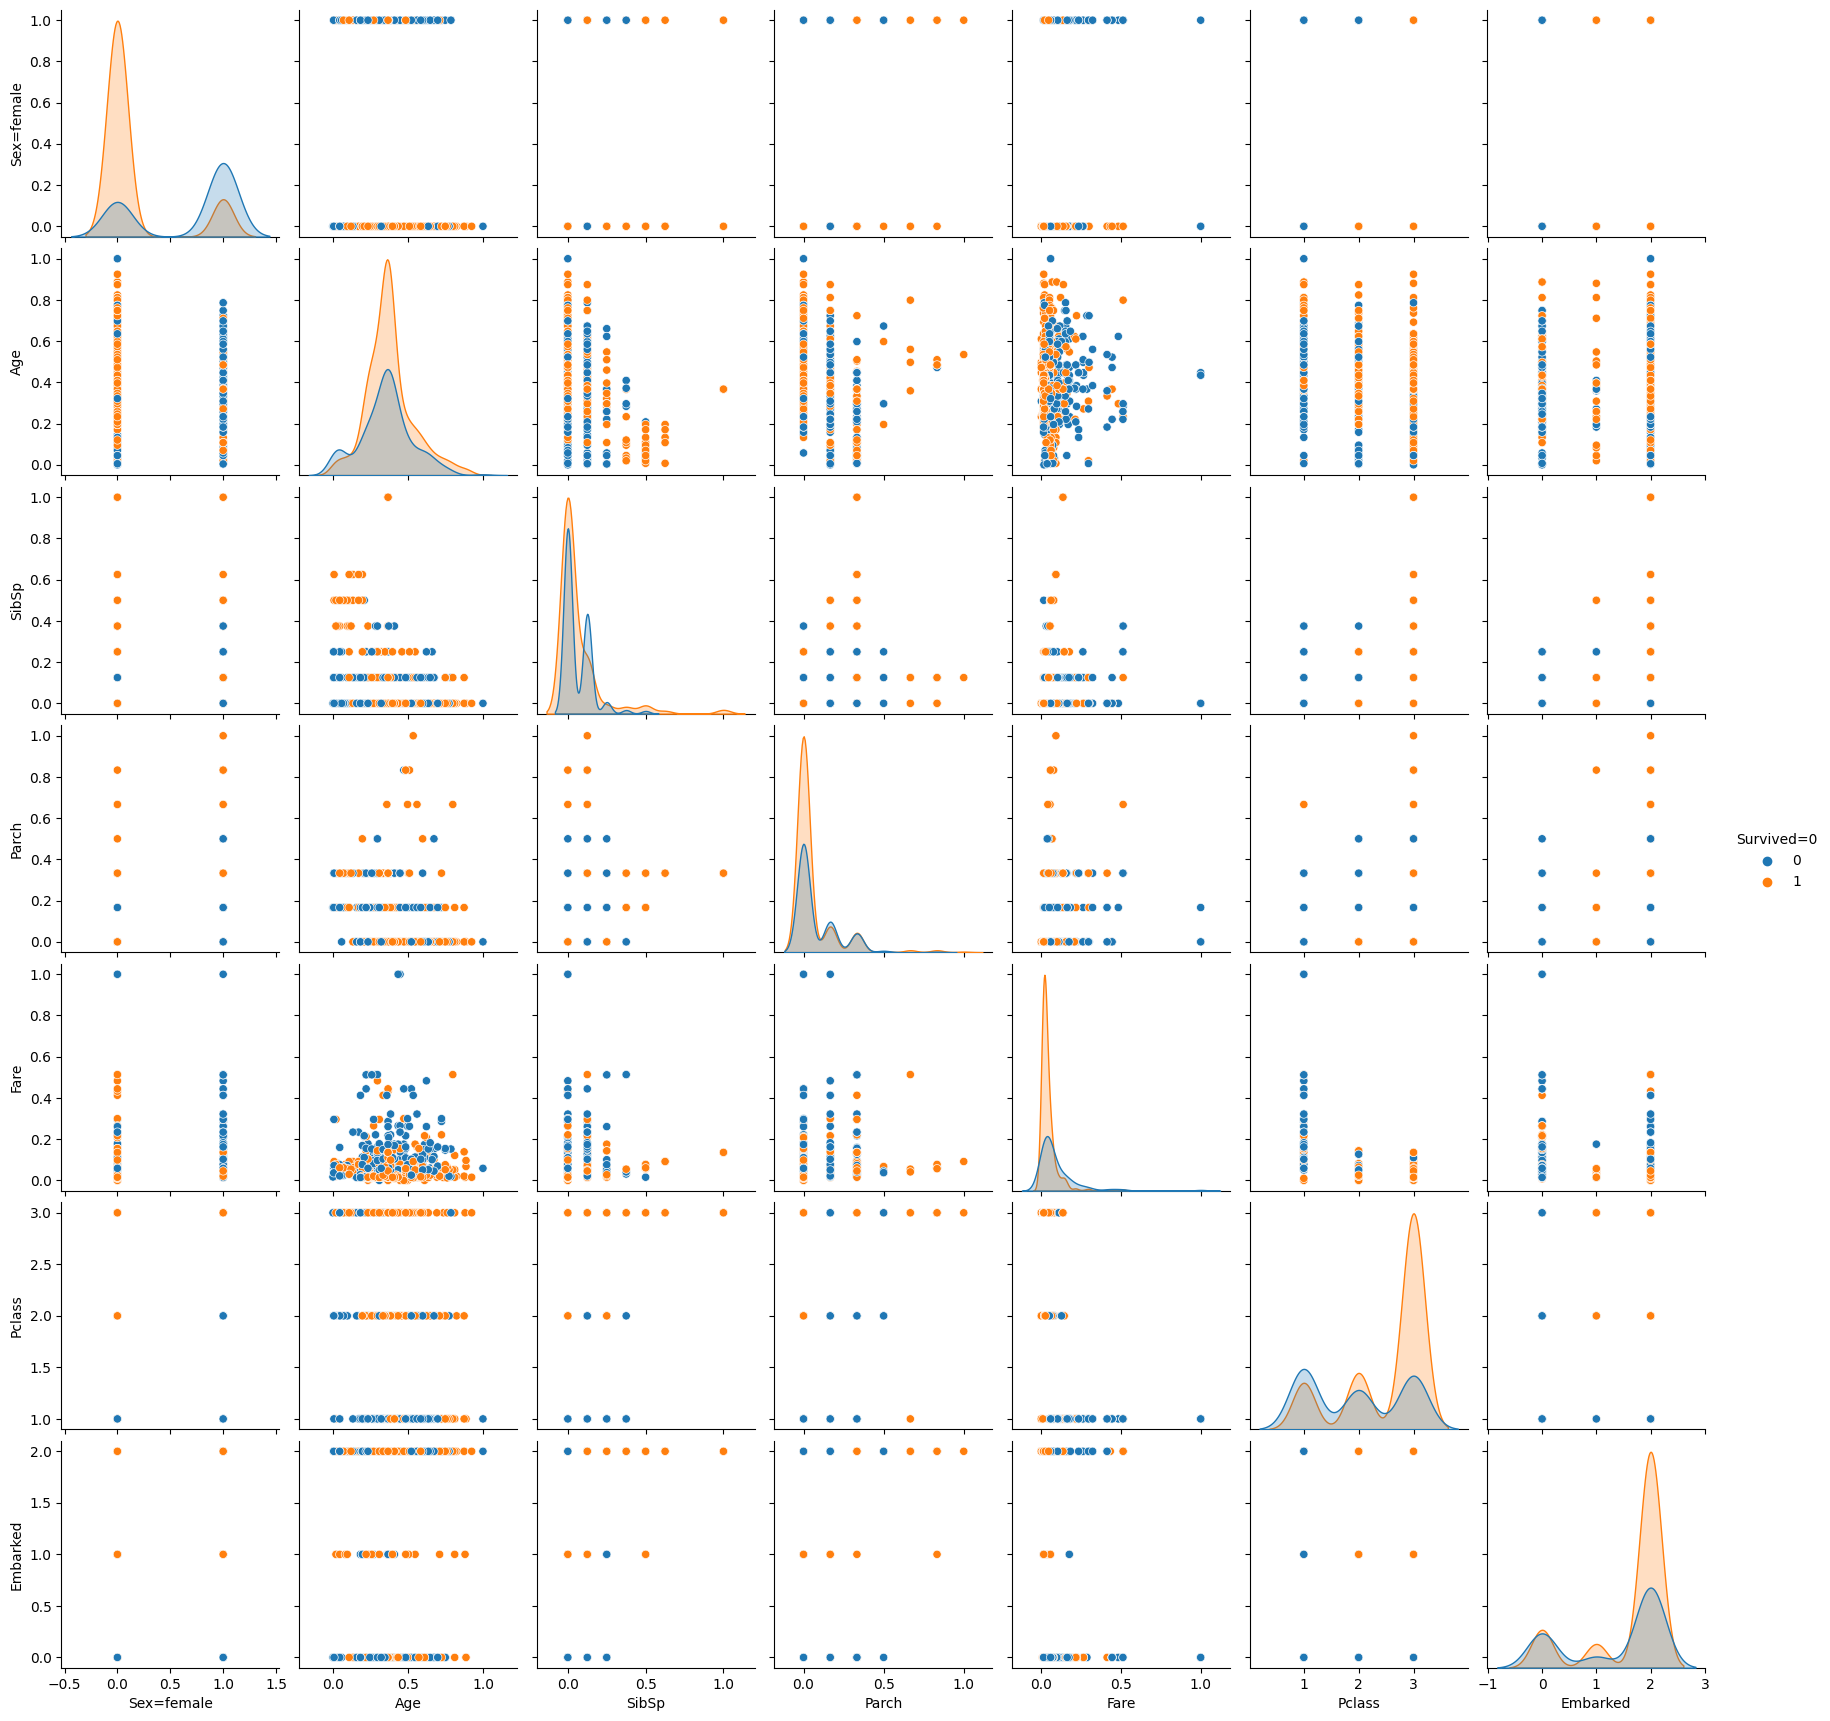

In [526]:
import seaborn as sns

sns.pairplot(
    data=train_data_for_visualization,
    hue='Survived=0'
)

From this we can see that a significantly higher percentage of male passengers did not survive compared to female passengers; that many more members of Pclass 3 did not survive compared to other Pclass values; and the same can be said about the Embarked value of S (2).

Now let's use different clustering algorithms on this data:

In [639]:
from sklearn.cluster import AgglomerativeClustering, Birch, BisectingKMeans, DBSCAN, KMeans, MeanShift, SpectralClustering

def to_percent(num):
    perc = round(100 * num, 2)
    
    if perc == int(perc):
        perc = int(perc)
    
    return perc

survivors_total = len(train_data_cleaned[train_data_cleaned['Survived'] == 1])
total_size = train_data_processed.shape[0]
    
# In abstract terms, this algorithms assigns to every cluster
# either predicting mostly survivors or predicting mostly non-survivors,
# and appends each cluster's accuracy to the total accuracy
# weighted according to the cluster's size. This way we can
# measure potential accuracy of clustering models even if their
# number of clusters is more than 2.
def accuracy(df, result):
    result = pd.DataFrame(result, columns=['Cluster'])
    
    accuracy = 0
    clusters = result['Cluster'].unique()
        
    n_clusters = len(clusters)
    for cluster in clusters:
        data_for_cluster = df.filter(items=result.index[result['Cluster'] == cluster], axis=0)
        cluster_size = data_for_cluster.shape[0]
        ones = data_for_cluster[data_for_cluster['Survived'] == 1].shape[0]
        zeroes = cluster_size - ones
        
        if zeroes > ones:
            accuracy += zeroes / total_size
        else:
            accuracy += ones / total_size
    
    return str(to_percent(accuracy))

def test(df, alg, args):
    model = alg(**args)
    result = model.fit_predict(df)
    
    return model, result

cache = {}

In [646]:
import math

def my_range():
    return range(2, 5)

test_cases = {
    KMeans: [{'n_init': 'auto', 'n_clusters': i} for i in my_range()],
    SpectralClustering: [{'n_clusters': i} for i in my_range()],
    AgglomerativeClustering: [{'n_clusters': i, 'linkage': l, 'compute_distances': True} for i in my_range() for l in ['ward', 'complete', 'average', 'single']],
    DBSCAN: [{'eps': round(0.1 + i * 0.1, 1), 'min_samples': 30 + j * 10} for i in range(10) for j in range(7)],
    Birch: [{'n_clusters': i, 'threshold': round(0.1 + 0.1 * t, 1), 'branching_factor': bf} for i in my_range() for t in range(8) for bf in range(5, 95, 5)],
}

def test_batch(df_cleaned, df_processed, test_cases, ignore_cache=False):
    # This uses caching in order to make running this cell repeatedly
    # after small changes in test_cases much faster
    results = []
    for key in test_cases:
        for args in test_cases[key]:
            if ignore_cache or (df_processed.shape[0], key, str(args)) not in cache:
                model, result = test(df_processed, key, args)
                cache[df_processed.shape[0], key, str(args)] = model, result
                results.append((model, result))
            else:
                results.append(cache[df_processed.shape[0], key, str(args)])

    # Remove duplicates by accuracy
    old_results = results
    results = []
    acc_present = set()
    for res in old_results:
        acc = accuracy(df_cleaned, res[1])
        if not acc in acc_present:
            acc_present.add(acc)
            results.append(res)

    # Sort by accuracy
    results.sort(key=lambda res: accuracy(df_cleaned, res[1]), reverse=True)
    
    return results

def get_best_results(results):
    best_results = []
    names_displayed = set()
    for res in results:
        full_name = str(res[0])
        name = full_name[:full_name.find('(')]

        if name in names_displayed:
            continue

        names_displayed.add(name)
        best_results.append(res)
        
    return best_results

results = test_batch(train_data_cleaned, train_data_processed, test_cases)
best_results = get_best_results(results)

# Prepare relevant data for display
rows = [(str(res[0]), accuracy(train_data_cleaned, res[1])) for res in best_results]

pd.DataFrame(rows, columns=['Algorithm', 'Accuracy'])

,Algorithm,Accuracy
0,"DBSCAN(eps=0.6, min_samples=30)",80.2
1,"KMeans(n_clusters=2, n_init='auto')",78.63
2,"Birch(branching_factor=15, threshold=0.4)",75.03
3,SpectralClustering(n_clusters=2),71.32
4,AgglomerativeClustering(compute_distances=True...,68.84


As we can see, in this case DBSCAN performs best with 80.2% accuracy in the best case, and AgglomerativeClustering performs the worst with 68.84% in the best case.

Let's use the Elbow method and look at the n_clusters values it suggests:

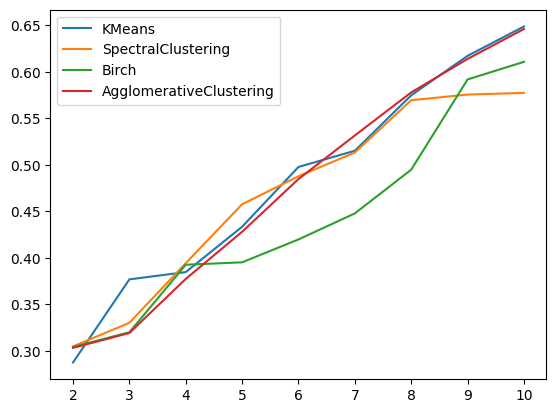

In [647]:
from sklearn.metrics import silhouette_score

def range_n_clusters():
    return range(2, 11)

def get_silhouette_scores(alg, args, df):
    silhouette_scores = []

    for n_clusters in range_n_clusters():
        model = alg(**args, n_clusters=n_clusters)
        result = model.fit_predict(df)
        
        silhouette_avg = silhouette_score(df, result)
        silhouette_scores.append(silhouette_avg)
        
    return silhouette_scores

for alg, args in [(KMeans, {'n_init': 'auto'}),
                  (SpectralClustering, {}),
                  (Birch, {'branching_factor': 5, 'threshold': 0.7}),
                  (AgglomerativeClustering, {}),]:
    sns.lineplot(
        x=range_n_clusters(), 
        y=get_silhouette_scores(alg, args, train_data_processed),
        label=alg.__name__
    )

Based on the graph we can interpret the optimal n_clusters value to be 2 for all algorithms, which is generally what we see in the test results (except KMeans, probably because of random initialization).

Now let's use PCA to reduce out features to 2 dimensions and visualize different clustering results:

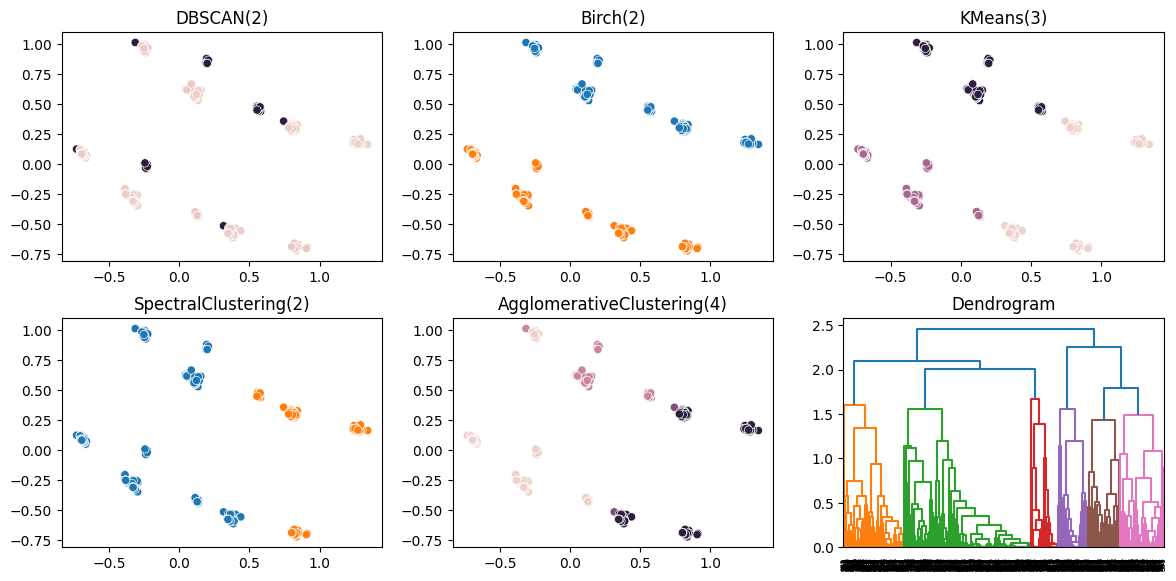

In [628]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

def visualize_results(df, results):
    df_reduced = PCA(n_components=2).fit_transform(df)
    df_reduced = pd.DataFrame(df_reduced, columns=['x', 'y'])

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    fig.tight_layout(pad=2)

    i = 0
    for res in results:

        clusters = pd.DataFrame(res[1], columns=['Cluster']).astype(np.uint8)
        data = pd.concat([df_reduced, clusters], axis=1)
        p = sns.scatterplot(data=data, x='x', y='y', hue='Cluster', ax=axes[int(i / 3), i % 3], legend=False)
        title = type(res[0]).__name__
        if hasattr(res[0], 'n_clusters'):
            title += f'({res[0].n_clusters})'
        else:
            title += '(2)'
        p.set(xlabel='', ylabel='', title=title)

        i += 1

    linkage_matrix = linkage(df, method='complete')
    dendrogram(linkage_matrix, ax=axes[int(i / 3), i % 3])
    axes[int(i / 3), i % 3].set_title('Dendrogram')

    plt.show()
    
visualize_results(train_data_processed, get_best_results(results))

And, finally, let's use the testing dataset to check if the accuracies of the best models will extend to it. First of all, we'll use the function accuracy() and rewrite it to determine the correct way to map existing clusters to the original Survived column's values of 0 and 1:

In [629]:
def clusters_to_predictions(df, res):
    survivors_total = len(df[df['Survived'] == 1])
    total_size = df.shape[0]

    res = pd.DataFrame(res, columns=['Cluster'])
    clusters = sorted(res['Cluster'].unique())
    ones = []
    zeroes = []
    n_clusters = len(clusters)
    for cluster in clusters:
        data_for_cluster = df.filter(items=res.index[res['Cluster'] == cluster], axis=0)
        cluster_size = data_for_cluster.shape[0]
        _ones = data_for_cluster[data_for_cluster['Survived'] == 1].shape[0]
        ones.append(_ones)
        zeroes.append(cluster_size - _ones)
    
    ones_sum = sum(ones)
    zeroes_sum = sum(zeroes)
    invert = True
    if abs(ones_sum - survivors_total) < abs(zeroes_sum - survivors_total):
        invert = False
        
    add_one = False
    
    if -1 in clusters:
        add_one = True
        
    def map_cluster(cluster):
        if add_one:
            cluster += 1
                        
        mapping = 1 if ones[cluster] > zeroes[cluster] else 0
        
        if invert:
            mapping = 1 - mapping
            
        return mapping
    
    return res['Cluster'].map(map_cluster).astype(np.uint8)

Now let's write a function that will use the function above to test results in a given index against the given dataframe:

In [630]:
def test_real_accuracy(df, cluster_data):
    total_size = df.shape[0]
    diff = (clusters_to_predictions(df, cluster_data) - df['Survived']).abs()
    matches = 1 - diff
    matches_count = matches.sum()
    
    perc = round(100 * matches_count / total_size, 2)
    if perc == int(perc):
        perc = int(perc)
        
    return str(perc) + '%'

Let's check if it works using our existing accuracy measurements:

In [633]:
for i, res in enumerate(best_results):
    row = rows[i]
    acc = row[1] + '%'
    real_acc = test_real_accuracy(train_data_cleaned, res[1])
    assert real_acc == acc, f'The results {acc} and {real_acc} do not match for model {row[0]}'

Now let's use what we have created to fit, predict and visualize clustering for the test data:

In [649]:
test_data_cleaned = clean_data(test_data)
test_data_processed, test_data_for_visualization = process_df(test_data_cleaned)

test_data_results = test_batch(test_data_cleaned, test_data_processed, test_cases)
best_results = get_best_results(test_data_results)
for res in best_results:
    print(str(res[0]), test_real_accuracy(test_data_cleaned, res[1]))

KMeans(n_clusters=2, n_init='auto') 100%
Birch(branching_factor=20, threshold=0.3) 94.48%
SpectralClustering(n_clusters=3) 93.29%
AgglomerativeClustering(compute_distances=True, n_clusters=3) 79.86%
DBSCAN(eps=0.6, min_samples=30) 73.38%


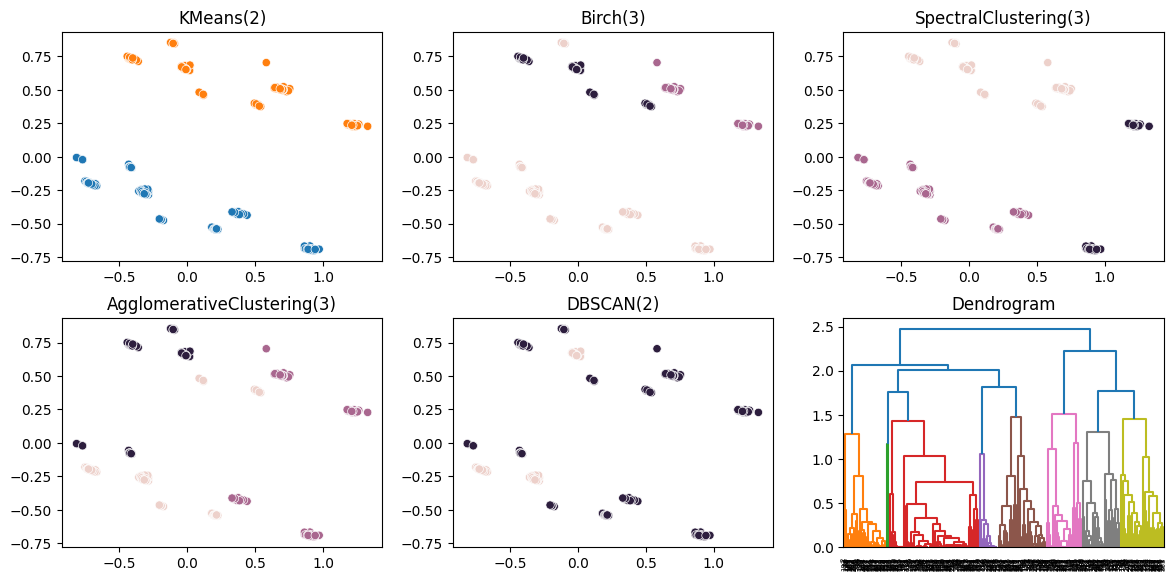

In [650]:
visualize_results(test_data_processed, best_results)

As we can see, the test data is generally much easier to predict. We had the same clustering with Birch(2) for the training data as with KMeans(2) for the testing data, but the accuracy here is 100%, while there it was below 80%.